# Autograd - 2 couche reseaux

On va créer une modele suivant avec l'autograd de PyTorch.

Lineaire --> Tanh --> Lineaire --> Logistic -> CrossEntropy

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
from Function import Function
from losses import MSE
from activations import TanhActivation, SigmoidActivation

from load_data import get_train_test_loaders

from torch.nn.modules.loss import CrossEntropyLoss

%load_ext autoreload
%autoreload 2

In [3]:
train_loader,test_loader, train_size, test_size = get_train_test_loaders(binary=False)

def get_minibatches(loader, device):
    for data, target in loader:
        normalize = torch.nn.BatchNorm2d(1)
        data = normalize(data)
        
        data = torch.squeeze(data)
        target = target.cuda(async=True)
        data = data.cuda(async=True)
        
        batch_n = data.size()[0]
        X = data.view(batch_n, -1)
        ones = torch.ones((X.size()[0], 1), device=device)
        X = torch.cat((X, ones), 1)
        
        y_onehot = torch.zeros((target.size()[0], 10), device=device)
        y_onehot.zero_()
        y_onehot.scatter_(1, target.view(-1,1), 1)
        
        X = torch.autograd.Variable(X)
        y = torch.autograd.Variable(y_onehot)
        yield X.t(), y

In [5]:
torch.cuda.set_device(0)
device = torch.device('cuda')
dtype = torch.float

layers_dims = [28*28 + 1, 128, 10]
batch_N = 64

activation1 = TanhActivation() # Tanh
activation2 = SigmoidActivation() # Sigmoid

loss_function = CrossEntropyLoss()
test_loss_function = CrossEntropyLoss()
function = Function()

w1 = torch.randn(layers_dims[1], layers_dims[0], dtype=dtype, device=device, requires_grad=True)
w2 = torch.randn(layers_dims[2], layers_dims[1], dtype=dtype, device=device, requires_grad=True)

with torch.no_grad():
    w1 *= 0.05
    w2 *= 0.05

errors = []
test_errors = []
accuracy = []

learning_rate = 1e-4
for t in range(600):
    
    epoch_loss = []
    for i,(X, y) in enumerate(get_minibatches(train_loader, device)):
        y_h1 = function.forward(w1, X)
        y_h2 = activation1.forward(y_h1)
        y_h3 = function.forward(w2, y_h2)
        y_pred = activation2.forward(y_h3).t()
        
        # replace nans with 0
        y_pred = torch.where(torch.isnan(y_pred), torch.zeros(1, device=device, dtype=dtype), y_pred)
                             
        loss = loss_function(y_pred, y.argmax(1))
        epoch_loss.append(loss.item())
        loss.backward()
        
        with torch.no_grad():
            #import pdb; pdb.set_trace()
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad

            # Manually zero the gradients after running the backward pass
            w1.grad.zero_()
            w2.grad.zero_()
    errors.append(np.array(epoch_loss).mean())
    
    if t % 10 == 0:
        with torch.no_grad():
            corrects = 0
            test_epoch_loss = []
            for i,(X, y) in enumerate(get_minibatches(test_loader, device)):
                y_h1 = function.forward(w1, X)
                y_h2 = activation1.forward(y_h1)
                y_h3 = function.forward(w2, y_h2)
                y_pred = activation2.forward(y_h3).t()

                test_loss = test_loss_function(y_pred, y.argmax(1))
                test_epoch_loss.append(test_loss.item())
                corrects += (y_pred.argmax(1) == y.argmax(1)).sum()

            test_errors.append((t, np.array(test_epoch_loss).mean()))
            accuracy.append(corrects.cpu().numpy() / test_size)
            print(t, loss.item())

0 2.2923989295959473
10 2.249753952026367
20 2.241396903991699
30 2.150480270385742
40 2.151261806488037
50 2.1466073989868164
60 2.1186318397521973
70 2.0257647037506104
80 2.0383858680725098
90 2.0681352615356445
100 2.1450116634368896
110 1.9879568815231323
120 1.9320026636123657
130 1.947105884552002
140 1.987924337387085
150 1.8582757711410522
160 1.9232360124588013
170 1.8711031675338745
180 1.8468153476715088
190 1.9558871984481812
200 2.040591239929199
210 1.9262630939483643
220 1.8248393535614014
230 1.8253458738327026
240 1.8114335536956787
250 1.9144514799118042
260 1.7801291942596436
270 1.8339366912841797
280 2.114084243774414
290 1.8261442184448242
300 1.8168941736221313
310 1.8276903629302979
320 2.0487921237945557
330 1.9152474403381348
340 2.237149238586426
350 1.7768776416778564
360 2.2747020721435547
370 1.908767580986023
380 1.8075296878814697
390 1.7952101230621338
400 1.8073632717132568
410 1.7766324281692505
420 2.0266222953796387
430 1.7361090183258057
440 2.238

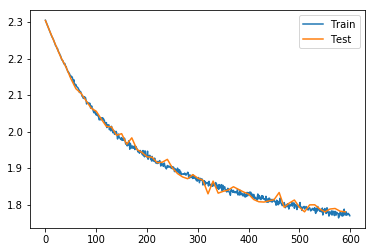

In [7]:
te = np.array(test_errors)
plt.plot(range(len(errors)), errors, label="Train")
plt.plot(te[:,0], te[:,1], label="Test")
plt.legend()

Selon les courbes d'erreur du train et test, ca semble que nous pourrions ameliorer encore. Par contre il faut prendre en compte la performance également et verifier, est-ce qu'il augmente toujours.

## Test

In [6]:
corrects = 0
for i,(X, y) in enumerate(get_minibatches(test_loader, device)):
    y_h1 = function.forward(w1, X)
    y_h2 = activation1.forward(y_h1)
    y_h3 = function.forward(w2, y_h2)
    y_pred = activation2.forward(y_h3).t()
    
    corrects += (y_pred.argmax(1) == y.argmax(1)).sum()
    
print(corrects.cpu().numpy() / test_size)

0.8265833333333333


Avec encore plus des iterations ou plus grand bas d'apprentissage, nous pourraions encore ameliorer l'accuracy.